In [1]:
import os
import numpy as np
import time
import sys
from PIL import Image
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from DatasetGenerator import DatasetGenerator
from torch.utils.data import DataLoader
from sklearn.metrics.ranking import roc_auc_score
from plots import plot_roc
from DensenetModels import DenseNet121

In [2]:
ratio = 2
nnClassCount = 14
root = f'checkpoints/unsup_{ratio}'

pathModel = f'{root}/best_auroc.pth.tar'

### dataloader

In [3]:
data_root = 'database/xrays'
file_test = 'new_split/test_list.txt'
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
test_transformSequence = transforms.Compose([
    transforms.Resize(256),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])) 
])
iniclude_nf = nnClassCount == 15
datasetTest = DatasetGenerator(data_root, file_test, transform=test_transformSequence, iniclude_nf=iniclude_nf)
dataLoaderTest = DataLoader(dataset=datasetTest, batch_size=32, num_workers=2, shuffle=False )


Number of images: 10510 with 14 class labels from file path database/xrays/new_split/test_list.txt 



### model loading

In [4]:
model = DenseNet121(nnClassCount, True).cuda()
modelCheckpoint = torch.load(pathModel)
model.load_state_dict(modelCheckpoint['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### test AUROC

In [5]:
from tqdm import tqdm

def computeAUROC(dataGT, dataPRED):
        
    outAUROC = []
    datanpGT = dataGT.cpu().numpy()
    datanpPRED = dataPRED.cpu().numpy()
    for i in range(nnClassCount):
        outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
    return outAUROC

#--------------------------------------------------------------------------------  

# def test ():
CLASS_NAMES = dataLoaderTest.dataset._class_labels

cudnn.benchmark = True
outGT = torch.FloatTensor().cuda()
outPRED = torch.FloatTensor().cuda()
model.eval()
for i, (input, target) in tqdm(enumerate(dataLoaderTest), total=len(dataLoaderTest)):
    with torch.no_grad():
        target = target.cuda()
        outGT = torch.cat((outGT, target), 0)
        bs, n_crops, c, h, w = input.size()
        varInput = torch.autograd.Variable(input.view(-1, c, h, w).cuda())
        out = model(varInput)
        outMean = out.view(bs, n_crops, -1).mean(1)
        outPRED = torch.cat((outPRED, outMean.data), 0)
aurocIndividual = computeAUROC(outGT, outPRED)

# plot_roc(outGT, outPRED, CLASS_NAMES)
aurocMean = np.array(aurocIndividual).mean()
print ('Test AUROC mean ', aurocMean)

f = open(f'{root}/test_auroc.txt', 'w')

f.write(f"Test AUROC mean:  {aurocMean:0.6f} \n ")       
for i in range (0, len(aurocIndividual)):
    print (CLASS_NAMES[i], ' ', aurocIndividual[i])
    f.write(f"{CLASS_NAMES[i]}:  {aurocIndividual[i]:0.6f} \n ")
f.close()
np.save(f"{root}/test_auroc_mean.npy", np.array([aurocMean]))

100%|██████████| 329/329 [02:26<00:00,  2.25it/s]


Test AUROC mean  0.6999809666682666
Atelectasis   0.7078254328788539
Cardiomegaly   0.7131125893373873
Consolidation   0.6286279887567803
Edema   0.7923225823315293
Effusion   0.7329744458873795
Emphysema   0.7842229529502845
Fibrosis   0.7372105545114623
Hernia   0.7339237949669742
Infiltration   0.6332443811286739
Mass   0.6597184128382925
Nodule   0.6607750005483394
Pleural_Thickening   0.6611449325936398
Pneumonia   0.5898101313320826
Pneumothorax   0.7648203332940524


### heatmap

In [6]:
arg = outPRED.argmax(dim=0).data.cpu().numpy()
im_infos = np.array(datasetTest._imdb)[arg]
heat_map_preds = outPRED[arg].data.cpu().numpy()

In [7]:
model_feats = model.densenet121.features
model_feats.eval()
#---- Initialize the weights
weights = list(model_feats.parameters())[-2]
transCrop = 224
#---- Initialize the image transform - resize + normalize
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
transformList.append(transforms.Resize(transCrop))
transformList.append(transforms.ToTensor())
transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

for index, info in enumerate(im_infos):     
    #---- Load image, transform, convert
    imageData = Image.open(info['im_path']).convert('RGB')
    imageData = transformSequence(imageData)
    imageData = imageData.unsqueeze_(0)

    input = torch.autograd.Variable(imageData)

    model_feats.cuda()
    output = model_feats(input.cuda())

    #---- Generate heatmap
    heatmap = None
    for i in range (0, len(weights)):
        map = output[0,i,:,:]
        if i == 0: heatmap = weights[i] * map
        else: heatmap += weights[i] * map

    #---- Blend original and heatmap 
    npHeatmap = heatmap.cpu().data.numpy()

    imgOriginal = cv2.imread(info['im_path'], 1)
    imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))

    cam = npHeatmap / np.max(npHeatmap)
    cam = cv2.resize(cam, (transCrop, transCrop))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

    img = heatmap * 0.5 + imgOriginal

    cv2.imwrite(f'{root}/{index}.png', img)
    f = open(f'{root}/{index}.txt', 'w')
    for index, value in enumerate(heat_map_preds[index]):
        f.write(f"{CLASS_NAMES[index]}:  {value:0.3f}           {'gt' if index in info['labels'] else ''} \n")
    
    f.close()            

### ROC Curve

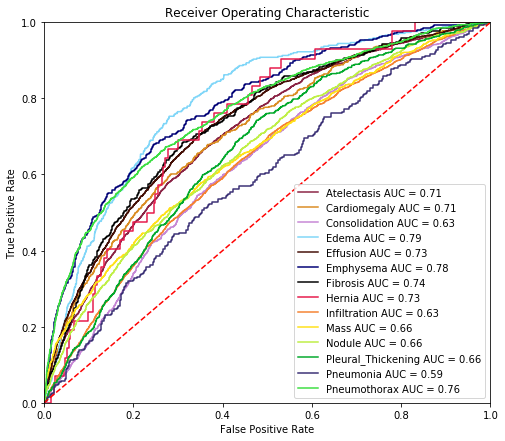

In [8]:
colors = ['#8a2244', '#da8c22', '#c687d5', '#80d6f8', '#440f06', '#000075', '#000000', '#e6194B', '#f58231', '#ffe119', '#bfef45',
'#02a92c', '#3a3075', '#3dde43', '#baa980', '#170eb8', '#f032e6', '#a9a9a9', '#fabebe', '#ffd8b1', '#fffac8', '#aaffc3', '#5b7cd4',
'#3e319d', '#a837b2', '#400dd2', '#f8d307']
gt = outGT.data.cpu().numpy()
preds = outPRED.data.cpu().numpy()
fig = plt.figure(figsize=(8, 7))
for i in range(len(CLASS_NAMES)):
    fpr, tpr, _ = metrics.roc_curve(gt[:, i], preds[:, i])
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, colors[i], label = f'{CLASS_NAMES[i]} AUC = {roc_auc:0.2f}')

plt.legend(loc = 'lower right', )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
fig.savefig(f'{root}/roc_curve.pdf')


### confusion_matrix

In [9]:
pred_01 = (preds > 0.1).astype(int)
cmat=metrics.multilabel_confusion_matrix(gt, pred_01, labels=None)
cmat.shape

(14, 2, 2)

### Training validation loss graph

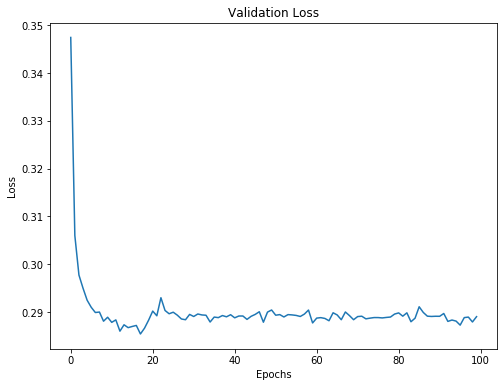

In [10]:
fig = plt.figure(figsize=(8, 6))
plt.title('Validation Loss')
v_loss = np.load(f"{root}/val_loss_epoch.npy")
plt.plot(v_loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
fig.savefig(f'{root}/val_loss.pdf')

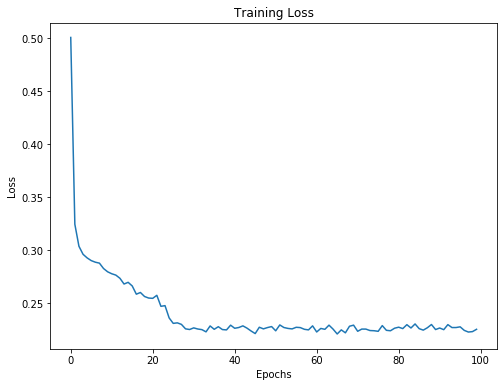

In [11]:

train_uda_loss = np.load(f"{root}/train_uda_loss.npy")
train_loss = np.load(f"{root}/train_loss.npy")
loss = train_uda_loss + train_loss
mean_loss = np.zeros((100))
iter_per_epoch = len(loss)//100

for i in range(100):
    mean_loss[i] = loss[i*iter_per_epoch: (i+1)*iter_per_epoch].mean()
    
fig = plt.figure(figsize=(8, 6))
plt.title('Training Loss')
plt.plot(mean_loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
fig.savefig(f'{root}/train_loss.pdf')

In [12]:
# sup 2 Test best AUROC mean  0.6902797700931337
